In [50]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from datetime import datetime
import pickle
from pathlib import Path
from os import listdir

In [51]:
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer
from bayes_opt import UtilityFunction
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

In [52]:
import cufflinks as cf
cf.go_offline()

# Run

In [53]:
%run SVR_MAPE_Library.ipynb

In [54]:
y1 =pd.read_excel(r'Data//Data1.xlsx').set_index("fecha").loc["2007-01-01":"2020-03-30"]
X1 = pd.read_csv("X.csv").set_index("fecha").loc["2007-01-01":"2020-03-30"]

X = X1.to_numpy(); y = y1.to_numpy()

In [57]:
def bas_optit(C, epsilon, gamma, mu, lmbda): 
#   n: test size, itr: # of iterations
    n = 7; itr = 52
    
    cas = {}; mape = []; it = itr+1
    yl = len(y)
    
    # parameters
    hyperparameters = {
        'kernel' : "rbf",
        'C' : C, 
        'epsilon' : epsilon, 
        'mu' : mu,
        'lmbda' : lmbda,
        'gamma' : gamma, 
    }
    
    cas[0] = hyperparameters
    
    itera = np.flip(np.arange(1, it))
    for i in itera:
        j = i*n
        
        # y, X split
        X_train = X[:yl - j, :]; X_test = X[yl - j : yl - (j-n), :]
        y_train = y[:yl - j];    y_test = y[yl - j : yl - (j-n)]
        
        # test index
        y_idx = y1.index[yl - j : yl - (j-n)]
        
        # rescale X and y
        scaler = MaxAbsScaler(); scaler.fit(X_train); 
        X_train = scaler.transform(X_train); X_test = scaler.transform(X_test)
        
        scaler1 = MaxAbsScaler(); scaler1.fit(y_train)
        y_train = scaler1.transform(y_train).reshape(-1)
        y_test = y_test.reshape(-1)
        

        # fit and predict
        model = SVR_general_cvxopt(**hyperparameters).fit(X_train, y_train)
        pred = model.predict(X_test)
        
        # rescale y_test
        y_pred = scaler1.inverse_transform(pred.reshape(-1, 1))
        
        # keep data
        yi = pd.DataFrame(y_test, index = y_idx, columns = ["real"])
        yi["predict"] = y_pred.reshape(-1)
        yi["resta"] = yi.real - yi.predict
        yi["error"] = (np.abs((yi.real - yi.predict)/yi.real))
        cas[i] = yi
        mape.append(yi.error.mean()*100)
    
    # Store prediction
    name_ = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")    
    with open(f'Pickles//prueba_calor_frio//{name_}', 'wb') as to_write:
        pickle.dump(cas, to_write)
    
    mape_mean = sum(mape)/itr
    
    return -mape_mean

In [58]:
    args = {
        'C' : 1.5622596668986724, 
        'epsilon' : 0.01, 
        'mu' : 0.8894683237212756,
        'lmbda' : 0.7147423174236999,
        'gamma' : 0.009632563464115184, 
    }  
    
mape = bas_optit(**args)

# Get the data

In [8]:
def open_pickle(path, files):
    tame = {}
    for ld in files:
        with open(f"{path}\\{ld}", 'rb') as f:
            tame[ld] = pickle.load(f)
    return tame

def join_pickle(pkls):
    li_n = {}
    for a in pkls.keys():
        li_n[a] = pd.DataFrame()
        for i in range(1, 53):
            li_n[a] = pd.concat([li_n[a], pkls[a][i]], axis = 0)
        li_n[a] = li_n[a].sort_index()
    return li_n

def concat_pred(j_p):
    pred_tot = pd.DataFrame()
    pred_tot["real"] = j_p[[*j_p.keys()][0]]['real']
    name = ['real']
    for a in j_p.keys():
        pred_tot = pd.concat([pred_tot, j_p[a]['predict']], axis = 1)
        name.append(a)
    pred_tot.columns = name
    return pred_tot

def concat_error(j_p):
    error_tot = pd.DataFrame()
    for a in j_p.keys():
        error_tot = pd.concat([error_tot, j_p[a]['error']], axis = 1)
    error_tot.columns = [*j_p.keys()]
    return error_tot

In [59]:
path = Path().resolve() / 'Pickles'/ 'prueba_calor_frio'
list_dir = listdir(path)
files = [ld for ld in list_dir if ld[-2:-1].isdigit()]

## New matrix

In [60]:
pkls = open_pickle(path, files)

join = join_pickle(pkls)

total = concat_pred(join)

error = concat_error(join)

### X 300 days prediction

In [106]:
mape = join["12_04_2021_14_54_21"].error.mean()*100
join["12_04_2021_14_54_21"][["real", "predict"]].iplot(title = f"MAPE: {mape:.2f}", xTitle = "date", yTitle = "consumption")

### X 365 days prediction

In [107]:
mape1 = join["12_04_2021_16_33_21"].error.mean()*100
join["12_04_2021_16_33_21"][["real", "predict"]].iplot(title = f"MAPE: {mape1:.2f}", xTitle = "date", yTitle = "Consumption")

### X 0 days prediction

In [108]:
mape2 = join["12_04_2021_17_49_00"].error.mean()*100
join["12_04_2021_17_49_00"][["real", "predict"]].iplot(title = f"MAPE: {mape2:.2f}", xTitle = "date", yTitle = "Consumption")

In [110]:
mape, mape1, mape2

(2.267261213663317, 2.2672636648124285, 2.267257406473959)

In [112]:
print(mape - mape1)
print(mape1 - mape2)

-2.4511491116818718e-06
6.258338469677938e-06


### X without gplearn

In [48]:
join.keys()

dict_keys(['12_04_2021_14_54_21', '12_04_2021_16_33_21', '12_04_2021_17_49_00', '13_04_2021_08_52_03', '13_04_2021_11_53_42', '13_04_2021_13_10_58'])

In [49]:
mape3 = join["13_04_2021_13_10_58"].error.mean()*100
join["13_04_2021_13_10_58"][["real", "predict"]].iplot(title = f"MAPE: {mape3:.2f}", xTitle = "date", yTitle = "Consumption")

In [62]:
mape_1 = join["13_04_2021_14_35_26"].error.mean()*100
join["13_04_2021_14_35_26"][["real", "predict"]].iplot(title = f"MAPE: {mape_1:.2f}", xTitle = "date", yTitle = "Consumption")

### Comparation with old matrix

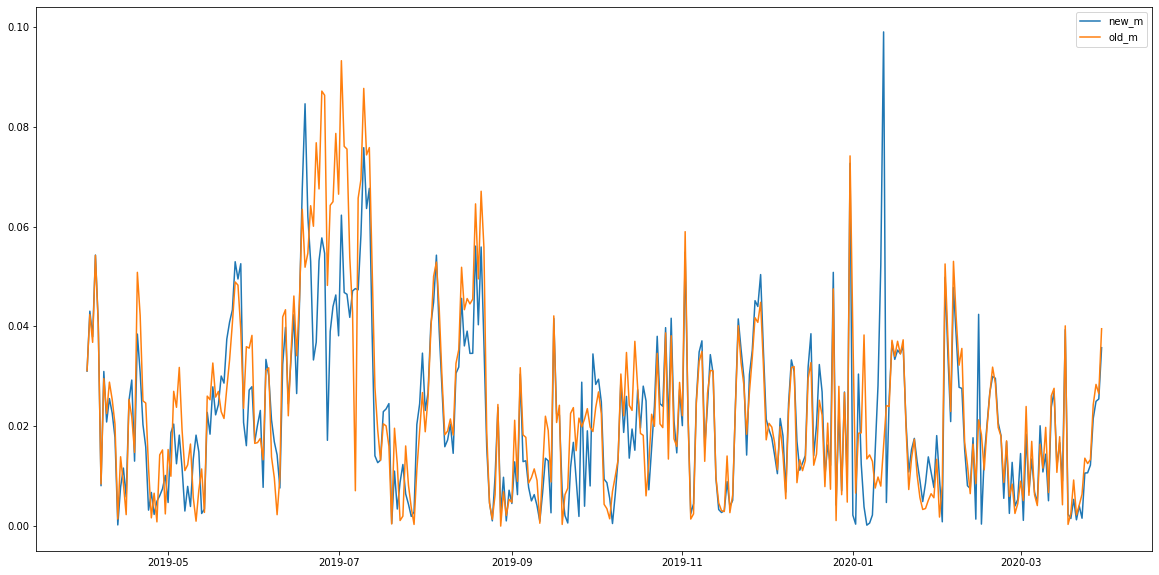

In [68]:
plt.figure(figsize = (20, 10))
plt.plot(join["13_04_2021_13_10_58"].error, label = "new_m")
plt.plot(join["13_04_2021_14_35_26"].error, label = "old_m")
plt.legend()

## Old Matrix

In [73]:
# list of Pickle files names
path = Path().resolve() / 'Pickles'/ 'K_75_52_mu_lambda'
list_dir = listdir(path)
files = [ld for ld in list_dir if ld[-2:-1].isdigit()]

In [74]:
pc = open_pickle(path, files)

jp = join_pickle(pc)

tot = concat_pred(jp)

er = concat_error(jp)

In [75]:
mape_ = jp[[*jp.keys()][-1]].error.mean()*100
jp[[*jp.keys()][-1]][["real", "predict"]].iplot(title = f"MAPE: {mape_:.2f}")

### Comparition against new matrix

In [ ]:
cono["error1"] = jp[[*jp.keys()][-1]][["error"]].copy()
cono["error2"] = join["12_04_2021_16_33_21"].error

In [90]:
cono.iplot()

### X without gplearn

In [61]:
join.keys()

dict_keys(['12_04_2021_14_54_21', '12_04_2021_16_33_21', '12_04_2021_17_49_00', '13_04_2021_08_52_03', '13_04_2021_11_53_42', '13_04_2021_13_10_58', '13_04_2021_14_35_26'])

In [62]:
mape_1 = join["13_04_2021_14_35_26"].error.mean()*100
join["13_04_2021_14_35_26"][["real", "predict"]].iplot(title = f"MAPE: {mape_1:.2f}", xTitle = "date", yTitle = "Consumption")

# Year behind

In [131]:
len(y1.loc["2018-04-02":"2019-03-30"].values)

363

In [132]:
len(jp[[*jp.keys()][-1]][["predict"]].values)

364

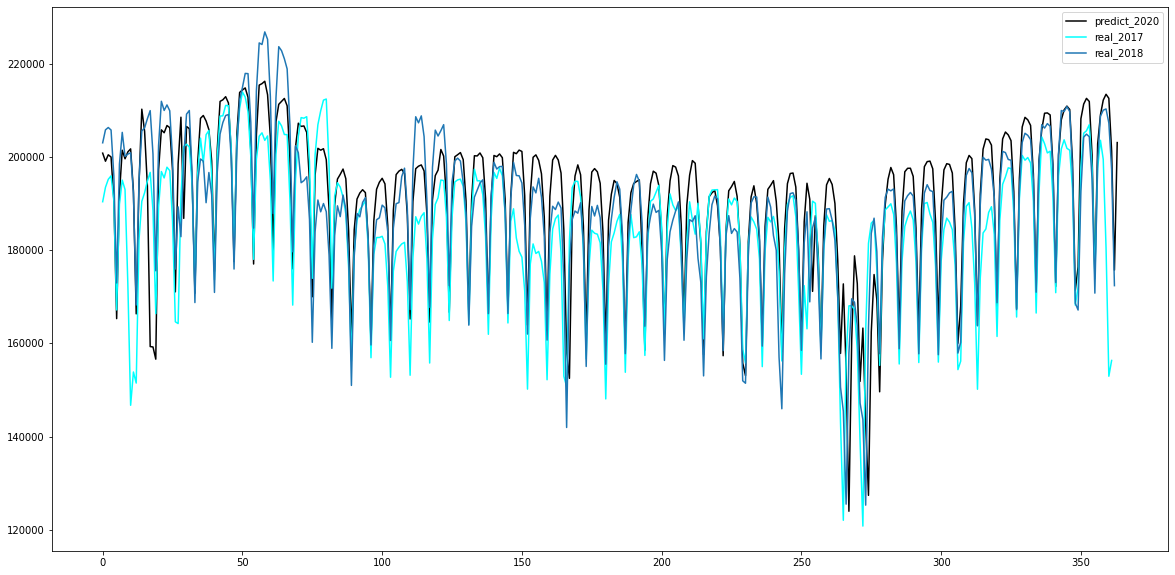

In [154]:
plt.figure(figsize = (20, 10))
plt.plot(jp[[*jp.keys()][-1]][["predict"]].values, label = "predict_2020", c = "black")
plt.plot(y1.loc["2017-04-04":"2018-03-31"].values, label = "real_2017", c = "cyan")
plt.plot(y1.loc["2018-04-03":"2019-03-31"].values, label = "real_2018")
plt.legend()

In [10]:
# list of Pickle files names
path = Path().resolve() / 'Pickles'/ 'prueba_calor_frio'
list_dir = listdir(path)
files = [ld for ld in list_dir if ld[-2:-1].isdigit()]

In [15]:
pkls = open_pickle(path, files)

join = join_pickle(pkls)

total = concat_pred(join)

error = concat_error(join)

In [17]:
join.keys()

dict_keys(['12_04_2021_14_54_21', '12_04_2021_16_33_21', '12_04_2021_17_49_00', '13_04_2021_08_52_03'])

### current X prediction

In [18]:
mapeo = join["13_04_2021_08_52_03"].error.mean()*100
join["13_04_2021_08_52_03"][["real", "predict"]].iplot(title = f"MAPE: {mapeo:.2f}", xTitle = "date", yTitle = "Consumption")

### Previous X prediction

In [34]:
# list of Pickle files names
path = Path().resolve() / 'Pickles'/ 'prueba_calor_frio'
list_dir = listdir(path)
files = [ld for ld in list_dir if ld[-2:-1].isdigit()]

In [35]:
pkls = open_pickle(path, files)

join = join_pickle(pkls)

total = concat_pred(join)

error = concat_error(join)

In [36]:
join.keys()

dict_keys(['12_04_2021_14_54_21', '12_04_2021_16_33_21', '12_04_2021_17_49_00', '13_04_2021_08_52_03', '13_04_2021_11_53_42'])

In [38]:
mapeo1 = join["13_04_2021_11_53_42"].error.mean()*100
join["13_04_2021_11_53_42"][["real", "predict"]].iplot(title = f"MAPE: {mapeo1:.2f}", xTitle = "date", yTitle = "Consumption")